# EVS-POT
Use a function to map the (DH0, n_sigma) to 1D and estimate the probability.

The function chosen for the main result, the lower bound

## Func. 1, lower bound
$$\text{lower bound} = \Delta H_0 - \Delta H_0/n_\sigma$$

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import genpareto
import matplotlib.pyplot as plt
from scipy.special import erfinv
import math
plt.style.use('./nice.mplstyle')

def load_data(file_path, data_type='mc'):
    data = pd.read_csv(file_path)
    if data_type == 'direct_compare':
        data['Delta_H0'] *= 100
    return data

def extract_data(data, relation):
    df = data[data['scaling_relation'] == relation]
    if 'DeltaH0' in df.columns:
        delta_h0 = df['DeltaH0'].values
    else:
        delta_h0 = df['$\Delta H_0\,(\%)$'].values
    if 'Significance $(\sigma)$' in df.columns:
        significance = df['Significance $(\sigma)$'].values
    else:
        significance = df['Significance'].values
    return delta_h0, significance

def calculate_sigma_p_value(delta_h0_proj, target_value):
    median = np.median(delta_h0_proj)
    sigma_84th = np.percentile(delta_h0_proj, 84)
    sigma = sigma_84th - median
    sigma_deviation = np.abs((target_value - median) / sigma)
    p_value_sigma = 1 - math.erf(sigma_deviation / np.sqrt(2))
    return sigma_deviation, p_value_sigma

def calculate_evt_p_value(delta_h0_proj, target_value, percentile=90):
    # Determine the threshold
    threshold = np.percentile(delta_h0_proj, percentile)
    exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold  # Tail data

    # Fit GPD to the tail data
    params = genpareto.fit(exceedances)
    shape, loc, scale = params

    # Tail survival probability (proportion of data in the tail)
    tail_prob = np.sum(delta_h0_proj >= threshold) / len(delta_h0_proj)

    if target_value > threshold:
        # Conditional probability adjusted to match at the threshold
        p_value_evt = (1 - genpareto.cdf(target_value - threshold, *params)) * tail_prob
    else:
        # Empirical CDF for the bulk region
        p_value_evt = np.sum(delta_h0_proj >= target_value) / len(delta_h0_proj)

    # Transform to sigma (Gaussian equivalent deviation)
    sigma_deviation = np.sqrt(2) * erfinv(1 - p_value_evt)

    return p_value_evt, sigma_deviation

# The first projection function
def default_proj(delta_H0, n_sigma):
    return delta_H0 - delta_H0 / n_sigma

The MCMC run, for Lx-T and Ysz-T, output data and plot.

Prob of obtaining (ΔH%, nσ) = [8.7 2.4] in LX-T.
Sigma deviation: 1.75σ, p-value: 0.0799
Probability of target value: 0.0839, (1.73sigma)
Frequentist: 0.08583959899749373


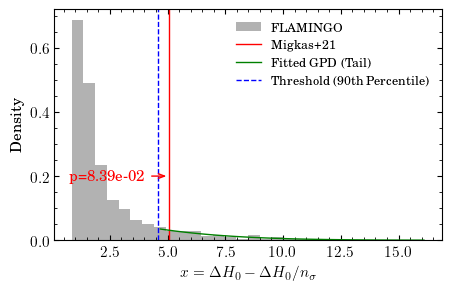

Prob of obtaining (ΔH%, nσ) = [14.   2.6] in YSZ-T.
Sigma deviation: 5.55σ, p-value: 2.84e-08
Probability of target value: 0.0045, (2.84sigma)
Frequentist: 0.00438871473354232


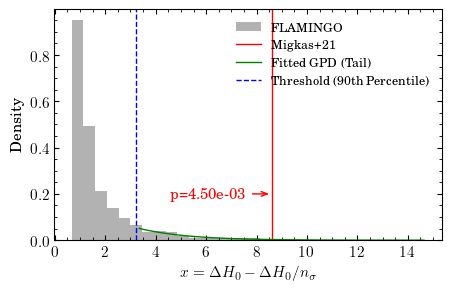

In [7]:
file_path_mc = '/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_mc_scatter.csv'
data_type_mc = 'mc'
data_mc = load_data(file_path_mc, data_type_mc)

target_point_arr_mc = [np.array([8.7, 2.4]), np.array([14, 2.6])]
for relation, target_point in zip(['LX-T', 'YSZ-T'], target_point_arr_mc):
    print(f'Prob of obtaining (ΔH%, nσ) = {target_point} in {relation}.')
    delta_h0, significance = extract_data(data_mc, relation)
    delta_h0_proj = default_proj(delta_h0, significance)
    target_value = default_proj(target_point[0], target_point[1])
    
    sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
    print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")
    
    percentile = 90
    p_value_evt, sigma_evt = calculate_evt_p_value(delta_h0_proj, target_value, percentile)
    print(f"Probability of target value: {p_value_evt:.3g}, ({sigma_evt:.3g}sigma)")
    
    threshold = np.percentile(delta_h0_proj, percentile)
    exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold
    params = genpareto.fit(exceedances)
    shape, loc, scale = params

    # One can get the frequency when the sigma value is low
    print(f'Frequentist:', np.sum(delta_h0_proj > target_value)/len(delta_h0_proj))
    
    # Plotting results
    plt.figure(figsize=(5, 3))
    plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='gray', label='FLAMINGO')
    x_vals = np.linspace(threshold, delta_h0_proj.max(), 100)
    gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile / 100)
    plt.axvline(target_value, color='red', linestyle='-', label=f'Migkas+21')
    plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')
    plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold ({percentile}th Percentile)')
    
    # Annotate the plot
    plt.annotate(f'p={p_value_evt:.2e}', 
         xy=(target_value, 0.2), xycoords='data',
         xytext=(target_value - 1, 0.2), textcoords='data',
         arrowprops=dict(arrowstyle='->,head_width=.15', color='red'),
         horizontalalignment='right', verticalalignment='center', color='red')

    plt.xlabel('$x=\\Delta H_0 - \\Delta H_0 / n_\\sigma$')
    plt.ylabel('Density')
    plt.legend(fontsize=9)

#     plt.savefig(f'./to_paper/evs_mcmc_{relation[1]}.pdf', bbox_inches='tight')   # save the figure
    plt.show()

The M21 fits, of Lx-T and Ysz-T separately. Data and plot below.

Prob of obtaining (ΔH%, nσ) = [8.7 2.6] in $L_\mathrm{{X}}-T$.
Sigma deviation: 1.96σ, p-value: 0.0497
Probability of target value: 0.0247, (2.25sigma)


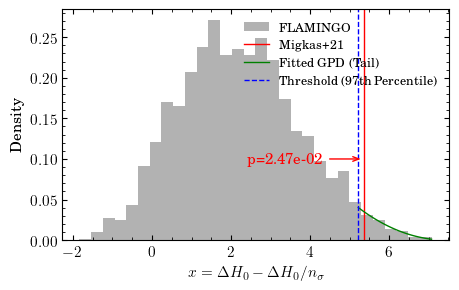

Prob of obtaining (ΔH%, nσ) = [14.   4.1] in $Y_\mathrm{{SZ}}-T$.
Sigma deviation: 6.42σ, p-value: 1.39e-10
Probability of target value: 1.81e-10, (6.38sigma)


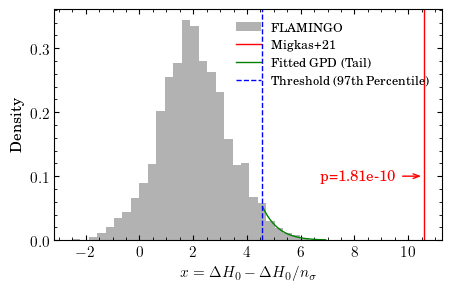

In [13]:
file_path_direct_compare = '/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_direct_compare.csv'
data_type_direct_compare = 'direct_compare'
data_direct_compare = load_data(file_path_direct_compare, data_type_direct_compare)

target_point_arr_direct_compare = [np.array([8.7, 2.6]), np.array([14, 4.1])]
for relation, target_point in zip(['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$'], target_point_arr_direct_compare):
    print(f'Prob of obtaining (ΔH%, nσ) = {target_point} in {relation}.')
    delta_h0, significance = extract_data(data_direct_compare, relation)
    delta_h0_proj = default_proj(delta_h0, significance)
    target_value = default_proj(target_point[0], target_point[1])
    
    sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
    print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")
    
    percentile = 97
    p_value_evt, sigma_evt = calculate_evt_p_value(delta_h0_proj, target_value, percentile)
    print(f"Probability of target value: {p_value_evt:.3g}, ({sigma_evt:.3g}sigma)")
    
    threshold = np.percentile(delta_h0_proj, percentile)
    exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold
    params = genpareto.fit(exceedances)
    shape, loc, scale = params
    
    # Plotting results
    plt.figure(figsize=(5, 3))
    plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='gray', label='FLAMINGO')
    x_vals = np.linspace(threshold, delta_h0_proj.max(), 100)
    gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile / 100)
    plt.axvline(target_value, color='red', linestyle='-', label=f'Migkas+21')
    plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')
    plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold ({percentile}th Percentile)')
    
    # Annotate the plot
    plt.annotate(f'p={p_value_evt:.2e}', 
         xy=(target_value, 0.1), xycoords='data',
         xytext=(target_value - 1, 0.1), textcoords='data',
         arrowprops=dict(arrowstyle='->,head_width=.15', color='red'),
         horizontalalignment='right', verticalalignment='center', color='red')

    plt.xlabel('$x=\\Delta H_0 - \\Delta H_0 / n_\\sigma$')
    plt.ylabel('Density')
    plt.legend(fontsize=9)

    plt.savefig(f'./to_paper/evs_m21_{relation[1]}.pdf', bbox_inches='tight')  # save the figure
    plt.show()

Now the MCMC joint result.

In [7]:
file_path_joint = '../data/analysis_all/h0_mc_joint_all.csv'
data_joint = load_data(file_path_joint, 'joint')
print(len(data_joint))
data_joint[data_joint['DeltaH0']>15]
# 1317 is bugged I recall

1727


,Unnamed: 0,relation1,relation2,delta,delta_err_lower,delta_err_upper,vlon,vlon_err_lower,vlon_err_upper,vlat,vlat_err_lower,vlat_err_upper,convergence_time,Lightcone,DeltaH0,Significance
1317,1317,LX-T,YSZ-T,0.234993,0.057829,0.056275,-35.730803,80.486451,41.765113,63.739565,18.7907,17.088909,271.646463,1318,46.998657,4.063588


1727
1726
Prob of obtaining (ΔH%, nσ) = [9.  5.4] in joint result.
Sigma deviation: 6.07σ, p-value: 1.27e-09
Probability of target value: 0.000222, (3.69sigma)


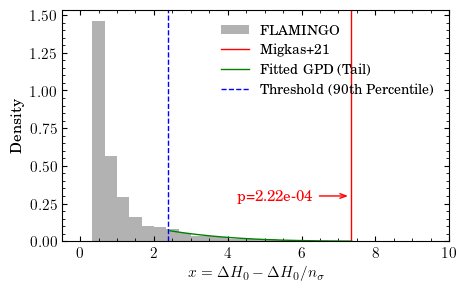

In [14]:
# ** This plot is put in the paper **
file_path_joint = '../data/analysis_all/h0_mc_joint_all.csv'
data_joint = load_data(file_path_joint, 'joint')
print(len(data_joint))
data_joint[data_joint['DeltaH0']>15]
data_joint = data_joint[data_joint['DeltaH0'] < 15]  # There is one point with extreme DeltaH0, 1317
print(len(data_joint))
target_point_joint = np.array([9.0, 5.4])

print(f'Prob of obtaining (ΔH%, nσ) = {target_point_joint} in joint result.')
delta_h0_joint = data_joint['DeltaH0'].values
significance_joint = data_joint['Significance'].values
delta_h0_proj_joint = default_proj(delta_h0_joint, significance_joint)
target_value_joint = default_proj(target_point_joint[0], target_point_joint[1])

sigma_deviation_joint, p_value_sigma_joint = calculate_sigma_p_value(delta_h0_proj_joint, target_value_joint)
print(f"Sigma deviation: {sigma_deviation_joint:.3g}σ, p-value: {p_value_sigma_joint:.3g}")

percentile_joint = 90
p_value_evt_joint, sigma_evt_joint = calculate_evt_p_value(delta_h0_proj_joint, target_value_joint, percentile_joint)
print(f"Probability of target value: {p_value_evt_joint:.3g}, ({sigma_evt_joint:.3g}sigma)")

threshold_joint = np.percentile(delta_h0_proj_joint, percentile_joint)
exceedances_joint = delta_h0_proj_joint[delta_h0_proj_joint > threshold_joint] - threshold_joint
params_joint = genpareto.fit(exceedances_joint)
shape_joint, loc_joint, scale_joint = params_joint

# Plotting results for joint result
plt.figure(figsize=(5, 3))
x_vals_joint = np.linspace(threshold_joint, delta_h0_proj_joint.max(), 100)
gpd_pdf_joint = genpareto.pdf(x_vals_joint - threshold_joint, shape_joint, loc_joint, scale_joint) * (1 - percentile_joint / 100)
plt.hist(delta_h0_proj_joint, bins=30, range=(0, 10), density=True, alpha=0.6, color='gray', label='FLAMINGO')
plt.axvline(target_value_joint, color='red', linestyle='-', label=f'Migkas+21')
plt.plot(x_vals_joint[1:], gpd_pdf_joint[1:], color='g', label='Fitted GPD (Tail)')
plt.axvline(threshold_joint, color='blue', linestyle='--', label=f'Threshold ({percentile_joint}th Percentile)')

# Annotate the plot
plt.annotate(f'p={p_value_evt_joint:.2e}', 
         xy=(target_value_joint, 0.3), xycoords='data',
         xytext=(target_value_joint - 1, 0.3), textcoords='data',
         arrowprops=dict(arrowstyle='->,head_width=.15', color='red'),
         horizontalalignment='right', verticalalignment='center', color='red')

plt.xlabel('$x=\\Delta H_0 - \\Delta H_0 / n_\\sigma$')
plt.ylabel('Density')
plt.xlim(right=10)
plt.legend(fontsize=10)

plt.savefig('./to_paper/evs_joint.pdf', bbox_inches='tight')
plt.show()

## Func. 2, Upper bound
$$\text{lower bound} = \Delta H_0 + \Delta H_0/n_\sigma$$

Prob of obtaining (ΔH%, nσ) = [8.7 2.4] in $L_\mathrm{{X}}-T$.
Sigma deviation: 1.5σ, p-value: 0.133
Probability of target value: 0.784, (0.274sigma)


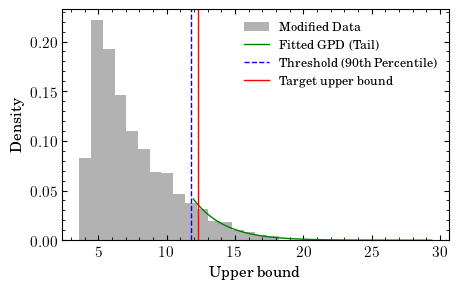

Prob of obtaining (ΔH%, nσ) = [14.   2.6] in $Y_\mathrm{{SZ}}-T$.
Sigma deviation: 5.95σ, p-value: 2.74e-09
Probability of target value: 0.000797, (3.35sigma)


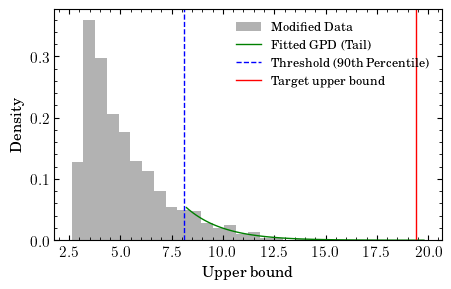

Prob of obtaining (ΔH%, nσ) = [8.7 2.6] in $L_\mathrm{{X}}-T$.
Sigma deviation: 3.24σ, p-value: 0.0012
Probability of target value: 0.0682, (1.82sigma)


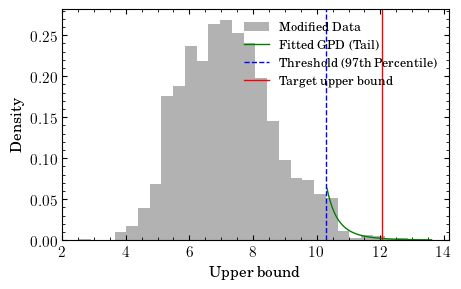

Prob of obtaining (ΔH%, nσ) = [14.   4.1] in $Y_\mathrm{{SZ}}-T$.
Sigma deviation: 8.8σ, p-value: 0
Probability of target value: 1.37e-05, (4.35sigma)


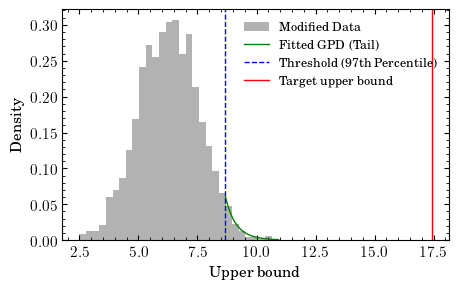

In [17]:
# The first projection function
def default_proj(delta_H0, n_sigma):
    return delta_H0 + delta_H0 / n_sigma

# Example usage for mc data
file_path_mc = '/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_mc_all.csv'
data_type_mc = 'mc'
data_mc = load_data(file_path_mc, data_type_mc)

target_point_arr_mc = [np.array([8.7, 2.4]), np.array([14, 2.6])]
for relation, target_point in zip(['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$'], target_point_arr_mc):
    print(f'Prob of obtaining (ΔH%, nσ) = {target_point} in {relation}.')
    delta_h0, significance = extract_data(data_mc, relation)
    delta_h0_proj = default_proj(delta_h0, significance)
    target_value = default_proj(target_point[0], target_point[1])
    
    sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
    print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")
    
    percentile = 90
    p_value_evt, sigma_evt = calculate_evt_p_value(delta_h0_proj, target_value, percentile)
    print(f"Probability of target value: {p_value_evt:.3g}, ({sigma_evt:.3g}sigma)")
    
    threshold = np.percentile(delta_h0_proj, percentile)
    exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold
    params = genpareto.fit(exceedances)
    shape, loc, scale = params
    
    # Plotting results
    plt.figure(figsize=(5, 3))
    plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='gray', label='Modified Data')
    x_vals = np.linspace(threshold, delta_h0_proj.max(), 100)
    gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile / 100)
    plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')
    plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold ({percentile}th Percentile)')
    plt.axvline(target_value, color='red', linestyle='-', label=f'Target upper bound')
    plt.xlabel('Upper bound')
    plt.ylabel('Density')
    plt.legend(fontsize=9)
    plt.show()

# Example usage for direct compare data
file_path_direct_compare = '/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_direct_compare.csv'
data_type_direct_compare = 'direct_compare'
data_direct_compare = load_data(file_path_direct_compare, data_type_direct_compare)

target_point_arr_direct_compare = [np.array([8.7, 2.6]), np.array([14, 4.1])]
for relation, target_point in zip(['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$'], target_point_arr_direct_compare):
    print(f'Prob of obtaining (ΔH%, nσ) = {target_point} in {relation}.')
    delta_h0, significance = extract_data(data_direct_compare, relation)
    delta_h0_proj = default_proj(delta_h0, significance)
    target_value = default_proj(target_point[0], target_point[1])
    
    sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
    print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")
    
    percentile = 97
    p_value_evt, sigma_evt = calculate_evt_p_value(delta_h0_proj, target_value, percentile)
    print(f"Probability of target value: {p_value_evt:.3g}, ({sigma_evt:.3g}sigma)")
    
    threshold = np.percentile(delta_h0_proj, percentile)
    exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold
    params = genpareto.fit(exceedances)
    shape, loc, scale = params
    
    # Plotting results
    plt.figure(figsize=(5, 3))
    plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='gray', label='Modified Data')
    x_vals = np.linspace(threshold, delta_h0_proj.max(), 100)
    gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile / 100)
    plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')
    plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold ({percentile}th Percentile)')
    plt.axvline(target_value, color='red', linestyle='-', label=f'Target upper bound')
    plt.xlabel('Upper bound')
    plt.ylabel('Density')
    plt.legend(fontsize=9)
    plt.show()